# Dataset Creation

(a template script for implementing each version of train/test/validation stuff)

This script is for creating balanced dataset for training/testing/validation purpose

It will change the label representing negative sentiment from -1 to 0 for easier training

It does not pre-process the data (e.g. stemming/removing symbols...)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from pathlib import Path
import random

random.seed(13)

dataset_heartless_path = Path('../../dataset/sa/dataset_cleaned_heartless.pkl').resolve()

dataset = pd.read_pickle(dataset_heartless_path)
# dataset = dataset.sample(frac=p)      # no sampling is needed

# convert the text to string object
dataset['review_text'] = dataset['review_text'].astype('str')

# drop any duplicate just in case
dataset = dataset.drop_duplicates(keep='first')

# replace -1 to 0
# then 0 = negative, 1 = positive
# for easier processing
dataset['review_score'] = dataset['review_score'].replace(-1, 0)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4891928 entries, 0 to 4891927
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   index         int64 
 1   app_id        int64 
 2   app_name      object
 3   review_text   object
 4   review_score  int64 
 5   review_votes  int64 
dtypes: int64(4), object(2)
memory usage: 223.9+ MB


In [2]:
dataset['review_text'] = dataset['review_text'].astype('str')

In [3]:
dataset = dataset.drop_duplicates(keep='first')

In [4]:
# remove rows have all whitespaces
dataset['num_of_words'] = dataset['review_text'].apply(lambda x:len(str(x).split()))
dataset = dataset[dataset['num_of_words'] > 0]

In [5]:
# remove number of rows that have less than N number of characters

character_limit = 20

dataset = dataset[dataset['review_text'].str.len()>=character_limit]

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4626526 entries, 1 to 4891927
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   index         int64 
 1   app_id        int64 
 2   app_name      object
 3   review_text   object
 4   review_score  int64 
 5   review_votes  int64 
 6   num_of_words  int64 
dtypes: int64(5), object(2)
memory usage: 282.4+ MB


In [12]:
# save the cleaned dataset to pickle

# dataset.to_pickle(Path('dataset_cleaned_heartless_cleaned.pkl').resolve())

---

Create both balanced and imbalanced validation dataset

In [7]:
# calculate ratio of class 0 and class 1

print('class 1 : class 0 = ', \
    float(len(dataset[dataset['review_score']==1]) / len(dataset[dataset['review_score']==0])))


class 1 : class 0 =  5.141156200721032


In [8]:
temp = dataset.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_score',ascending=True)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
0,0,753364
1,1,3873162


/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and

<Axes: ylabel='review_text'>

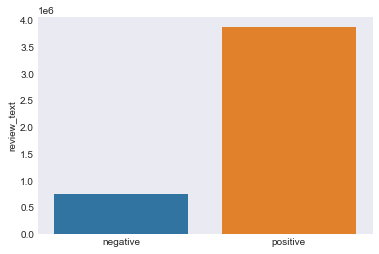

---

Create
- A fixed imbalanced validation set (0.1 of the original dataset) (using df.sample func)
- A fixed balanced validation set (0.1 of the original negative samples)
- A subset of dataset for creating training and testing data (due to computational power)

The rest of the data will be for training/testing

No data augmentation will be performed on both of them

Create train-test and validation set

In [9]:
VALIDATION_IMBALANCED_RATIO = 0.2
VALIDATION_BALANCED_RATIO = 0.2

validation_imbalanced_n = int(len(dataset) * VALIDATION_IMBALANCED_RATIO)
validation_balanced_n = int(len(dataset[dataset['review_score']==0]) * VALIDATION_BALANCED_RATIO)

In [10]:
validation_imbalanced_df = dataset.sample(n=validation_imbalanced_n, random_state=2023)

dataset.drop(validation_imbalanced_df.index, inplace=True)

class_0_balanced = dataset[dataset['review_score']==0].sample(n=int(validation_balanced_n), random_state=2024)
class_1_balanced = dataset[dataset['review_score']==1].sample(n=int(validation_balanced_n), random_state=2025)

validation_balanced_df = pd.concat([class_0_balanced, class_1_balanced])
validation_balanced_df = validation_balanced_df.sample(frac=1, random_state=0)

dataset.drop(validation_balanced_df.index, inplace=True)

In [11]:
# X_imbal_valid = validation_imbalanced_df['review_text'].to_numpy()
# y_imbal_valid = validation_imbalanced_df['review_score'].to_numpy()

# X_bal_valid = validation_balanced_df['review_text'].to_numpy()
# y_bal_valid = validation_balanced_df['review_score'].to_numpy()

In [25]:
validation_imbalanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 925305 entries, 1752495 to 4683282
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         925305 non-null  int64 
 1   app_id        925305 non-null  int64 
 2   app_name      925305 non-null  object
 3   review_text   925305 non-null  object
 4   review_score  925305 non-null  int64 
 5   review_votes  925305 non-null  int64 
 6   num_of_words  925305 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 56.5+ MB


In [27]:
temp = validation_imbalanced_df.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_score',ascending=True)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
0,0,150928
1,1,774377


In [26]:
validation_balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301344 entries, 2447379 to 2758277
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         301344 non-null  int64 
 1   app_id        301344 non-null  int64 
 2   app_name      301344 non-null  object
 3   review_text   301344 non-null  object
 4   review_score  301344 non-null  int64 
 5   review_votes  301344 non-null  int64 
 6   num_of_words  301344 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 18.4+ MB


In [28]:
temp = validation_balanced_df.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_score',ascending=True)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
0,0,150672
1,1,150672


In [12]:
# remaining comments

temp = dataset.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_score',ascending=True)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
0,0,451764
1,1,2948113


---

Create training and testing dataset from here :D

Sample a fixed amount of comments from here 

baseline (imbalanced): positive comments : negative comments = 5:1

baseline (balanced): positive comments : negative comments = 1:1

In [46]:
POS_NEG_RATIO = 5/1

N_NEG_LIST = [20, 40, 80]
N_NEG_LIST_INDEX = 2

N_total = N_NEG_LIST[N_NEG_LIST_INDEX] * 1000 + int(N_NEG_LIST[N_NEG_LIST_INDEX] * 1000 * POS_NEG_RATIO)

In [47]:
# for imabalnced dataset sampling


n_neg = N_NEG_LIST[N_NEG_LIST_INDEX] * 1000
n_pos = int(n_neg * POS_NEG_RATIO)

# get the negative reviews by sampling
# the negative reviews are the one with review_score = 0
neg_sampled_df = dataset[dataset['review_score']==0].sample(n=n_neg, random_state=2348)
pos_sampled_df = dataset[dataset['review_score']==1].sample(n=n_pos, random_state=2349)

dataset_imbal = pd.concat([pos_sampled_df, neg_sampled_df])

dataset_imbal = dataset_imbal.sample(frac=1, random_state=0)
dataset_imbal = dataset_imbal.sample(frac=1, random_state=12152350)

In [48]:
# for balanced dataset sampling

n_neg = int(N_total / float(2))
n_pos = n_neg

# get the negative reviews by sampling
# the negative reviews are the one with review_score = 0
# using same seed as imbalanced dataset will result in some same sampled data
# can better conclude that extra negative samples can do better 
neg_sampled_df = dataset[dataset['review_score']==0].sample(n=n_neg, random_state=2348)
pos_sampled_df = dataset[dataset['review_score']==1].sample(n=n_pos, random_state=2349)

dataset_bal = pd.concat([pos_sampled_df, neg_sampled_df])

dataset_bal = dataset_bal.sample(frac=1, random_state=0)
dataset_bal = dataset_bal.sample(frac=1, random_state=12152350)

In [49]:
dataset_imbal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480000 entries, 1714733 to 4441076
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         480000 non-null  int64 
 1   app_id        480000 non-null  int64 
 2   app_name      480000 non-null  object
 3   review_text   480000 non-null  object
 4   review_score  480000 non-null  int64 
 5   review_votes  480000 non-null  int64 
 6   num_of_words  480000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 29.3+ MB


In [50]:
temp = dataset_imbal.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_score',ascending=True)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
0,0,80000
1,1,400000


In [51]:
dataset_imbal.head()

,index,app_id,app_name,review_text,review_score,review_votes,num_of_words
1714733,2158625,238960,Path of Exile,Having never played Diablo 3 but loving the se...,1,0,51
3049928,4035218,312990,The Expendabros,"Guns, explosions, muscles, and manly character...",0,0,50
3174509,4202570,323470,DRAGON BALL XENOVERSE,"He's name is Goku, Son-Goku and he's nice. The...",1,1,11
2999189,3975619,310950,Street Fighter V,Offline is fine now that there's some single p...,0,1,163
1854934,2309233,241930,Middle-earth™: Shadow of Mordor™,Simply brilliant. I'm still astonished with th...,1,0,103


In [52]:
dataset_bal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480000 entries, 4390152 to 3122119
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         480000 non-null  int64 
 1   app_id        480000 non-null  int64 
 2   app_name      480000 non-null  object
 3   review_text   480000 non-null  object
 4   review_score  480000 non-null  int64 
 5   review_votes  480000 non-null  int64 
 6   num_of_words  480000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 29.3+ MB


In [53]:
temp = dataset_bal.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_score',ascending=True)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
0,0,240000
1,1,240000


In [54]:
dataset_bal.head()

,index,app_id,app_name,review_text,review_score,review_votes,num_of_words
4390152,5845320,49540,Aliens: Colonial Marines,Absolutely Terrible.,0,0,2
2967287,3925305,306680,Lexica,You can't replay old levels wtf??,0,0,6
3940563,5220173,397950,Clustertruck,"good, if yu have a fast computer",0,0,7
499487,556279,203750,Binary Domain,"The core gameplay is mostly enjoyable, but it'...",0,0,93
1854934,2309233,241930,Middle-earth™: Shadow of Mordor™,Simply brilliant. I'm still astonished with th...,1,0,103


In [55]:
# common rows in both dataset_bal and dataset_imbal

common = pd.merge(dataset_bal, dataset_imbal, how='inner', on=['index'])
common.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320000 entries, 0 to 319999
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           320000 non-null  int64 
 1   app_id_x        320000 non-null  int64 
 2   app_name_x      320000 non-null  object
 3   review_text_x   320000 non-null  object
 4   review_score_x  320000 non-null  int64 
 5   review_votes_x  320000 non-null  int64 
 6   num_of_words_x  320000 non-null  int64 
 7   app_id_y        320000 non-null  int64 
 8   app_name_y      320000 non-null  object
 9   review_text_y   320000 non-null  object
 10  review_score_y  320000 non-null  int64 
 11  review_votes_y  320000 non-null  int64 
 12  num_of_words_y  320000 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 31.7+ MB


---

Save dataset for training/testing/validation

In [56]:
from datetime import datetime

dataset_output_folder_path = Path('sampled_{}k_{}/'.format(int(N_total/1000), datetime.today().strftime("%Y-%m-%d"))).resolve()
dataset_val_output_folder_path = Path('sampled_valid_{}/'.format(datetime.today().strftime("%Y-%m-%d"))).resolve()

if not dataset_output_folder_path.exists():
    dataset_output_folder_path.mkdir(parents=True, exist_ok=True)

if not dataset_val_output_folder_path.exists():
    dataset_val_output_folder_path.mkdir(parents=True, exist_ok=True)

In [57]:
# save datasets

if not Path(dataset_val_output_folder_path, 'validation_balanced.pkl').exists():
    validation_balanced_df.to_pickle(dataset_val_output_folder_path / 'validation_balanced.pkl')

if not Path(dataset_val_output_folder_path, 'validation_imbalanced.pkl').exists():
    validation_imbalanced_df.to_pickle(dataset_val_output_folder_path / 'validation_imbalanced.pkl')

dataset_bal.to_pickle(dataset_output_folder_path / 'dataset_bal_sampled_{}k.pkl'.format(int(N_total/1000)))
dataset_imbal.to_pickle(dataset_output_folder_path / 'dataset_imbal_sampled_{}k.pkl'.format(int(N_total/1000)))
